In [1]:
import math
import numpy as np
import scipy as sp
import pandas as pd
import pickle
import os
import random
import re
from matplotlib import pyplot as plt
from scipy import stats, io, optimize, integrate, interpolate

import seaborn as sns

pd.set_option('display.width', 180)
np.set_printoptions(precision=4)

In [2]:
#if analysing PI the use: ExperimentLog_OutlierPIErrorDistboxplot.csv
#If analysing AI then use: ExperimentLog_AIOutliersSimple.csv

#Path to data: change it according to your data path
root_folder = '/Users/username/'
data_folder = "Model_data_latest"
data_filename = "ExperimentLog_OutlierPIErrorDistboxplot.csv"

In [3]:
path_count = 22
stop_count = 3
segment_count = stop_count - 1
values_per_stop = 4 # PI resp. start, end, AI resp. start, end

# SUPER IMPORTANT! Parameter values are limited to differ from zero by at least this number.
# It does not affect the precision of the result, but lower value causes big errors due to floating point
# interpretation of the numbers.
epsilon64 = np.sqrt(np.finfo(np.float32).eps)

In [4]:
paths = [["-1,25;1,1;2,7;2,7;-70;10;-40;-60;40", np.array([4, 3, 3])],
        ["-0,5;2,1;2,7;2,7;-50;-140;-30;-160;-100", np.array([2, 3, 3])],
        ["1,2;1,1;2,7;2,7;-120;-150;-170;-110;-90", np.array([2.5, 3, 2])],
        ["0,9;0,9;2,7;2,7;-110;130;-80;180;110", np.array([2, 3, 3])],
        ["0;-2,3;2,7;2,7;105;28;120;15;90", np.array([3.7, 3.2, 2])],
        ["2,2;-1,7;2,7;2,7;120;-160;160;90;-140", np.array([2, 4, 3])],
        ["1;-1;2,7;2,7;120;-160;90;-160;-90", np.array([1, 2, 2])],
        ["-1.4;-1,8;2,7;2,7;60;-10;35;90;-50", np.array([3, 4.5, 4.5])],
        ["-0,8;1,1;2,7;2,7;-20;-120;0;-100;-170", np.array([2, 2, 2])],
        ["1,6;0,9;2,7;2,7;-110;170;-90;180;135", np.array([4, 3, 3])],
        ["-1;-2,1;2,7;2,7;30;120;10;100;170", np.array([3, 3, 2])],
        ["-1.9;0;2,7;2,7;30;-60;50;-80;0", np.array([0, 3, 2])],
        ["1.2;0;2,7;2,7;150;-120;130;-100;180", np.array([0, 3, 2])],
        ["-1,9;0,2;2,7;2,7;40;-55;80;10;-70", np.array([2, 3, 3])],
        ["1.8;-1;2,7;2,7;135;-135;100;180;-110", np.array([3, 3, 2])],
        ["-0.5;-1;2,7;2,7;80;-70;30;180;-25", np.array([4, 4.5, 4])],
        ["0.7;2,1;2,7;2,7;-140;-50;-165;-70;-30", np.array([3, 3, 2])],
        ["0.5;-1.3;2,7;2,7;140;50;170;90;10", np.array([3, 3, 3])],
        ["-0,2;1.6;2,7;2,7;-130;-50;-150;-20;-80", np.array([5, 5, 3])],
        ["1,3;3,5;3;3;120;-160;160;90;-80", np.array([2, 4, 2])],
        ["2,5;5,5;3;3;120;-160;160;90;-80", np.array([2, 4, 2])],
        ["-6;5;3.5;3.5;30;-60;50;-80;0", np.array([0, 3, 2])],]

# Helper functions

## General

In [5]:
def clamp_pi(angle):
  # Puts angle in radians between [-pi, pi)
  return (angle + np.pi) % (2 * np.pi) - np.pi

def to_vec(distance, angle):
  # Convert from radial to cartesian
  return distance * np.array([np.cos(angle), np.sin(angle)])

def convert_unity_angle(angle):
    return -(angle - 90)

def regularize_param(param):
  # Used to avoid the leak too close to 0 (and thus causing numerical issues)
  return param if np.abs(param) > epsilon64 else (epsilon64 * np.sign(param) if param != 0 else epsilon64)

def get_rand_key(source_dict):
    keys = list(source_dict.keys())
    rand_i = random.randrange(0,len(keys))
    return keys[rand_i]

def t_split(joint_list):
    # We keept all the data vectorized => if individual trials are needed we have to split them
    result = []
    if len(joint_list) % segment_count != 0:
        raise ValueError("Cannot split data into trials, must be divisible by segment_count")
    while len(joint_list) > 0:
        result.append(joint_list[:segment_count])
        joint_list = joint_list[segment_count:]
    return result

def t_join(split_list):
    # Vectorize info from a sequence of trials
    return np.concatenate(split_list)

## Paths

In [6]:
def point(C, R, omega, use_deg=False):
    """
    Auxiliary function for a point on a circle with center C of radius R corresponding to angle omega.
    """
    half_circle = 180 if use_deg else math.pi
    return [C[0] + R*np.cos(np.pi*omega/half_circle), C[1] + R*np.sin(np.pi*omega/half_circle)]

def split_path_string(path_str, point_count):
    """
    We create control points and derivateives from path string, where point_count = n+1
    
    x_start;y_start;[d_0;...;d_n];[o_0;...;o_n];[t_0;...;t_n+1]
    
    such that:
    * x_start, y_start are the coordinates of the zeroth control point
    * d_0;...;d_n re the beeline distances between subsequent control points
    * o_0;...;o_n are the (absolute) orientations of the next control point relative to the previous one
    * t_0;...;t_n+1 are tangents (i.e. the facing direction) at each of the control points
    
    e.g.: path_str_to_points("-1;-2,4;2,5;3;2;105;8;120;110;5;40;140", 4)
    """
    ref_str = path_str.replace(",", ".").split(";")
    data = list(map(float, ref_str))
    stop_count = point_count - 1
    origin, rest = data[0:2], data[2:]
    dists, rest = rest[0:stop_count], rest[stop_count:]
    oris, rest = rest[0:stop_count], rest[stop_count:]
    tans = rest
    return origin, dists, oris, tans

def info_to_path(origin, dists, oris, tans):
    # construction of control points
    point_count = len(tans)
    stop_count = point_count - 1
    ctrl_points = [origin]
    for i in range(0, stop_count):
        new_point = point(ctrl_points[-1], dists[i], oris[i], True)
        ctrl_points.append(new_point)
        
    derivatives = [point([0,0], 1, tans[i], True) for i in range(point_count)]
    return ctrl_points, derivatives

def spline_from_points(ctrl_points, derivatives, scales):
    """
    Creates a spline from control points and derivatives
    
    We also need an array of scales at each control point, which determine the shape of the graph.
    Loosely speaking, the larger the scale at a control point, the less curved path at the control point.
    """
    # apply scaling
    scaled_derivatives = np.transpose(scales * np.transpose(derivatives))
    # the domain of the spline, spline(0) is the origin, spline(1) the 1st control point etc
    domain = range(len(ctrl_points))
    return interpolate.CubicHermiteSpline(domain, ctrl_points, scaled_derivatives)

def show_spline(spline):
    """
    Plots the spline and stop points at segments
    """
    samples = np.linspace(0, spline.x[-1], 1000)
    y = spline(samples)
    # plot the curve
    plt.scatter(y[:,0], y[:,1], c="y", s=1)
    # plot control points in different color
    values = np.array([spline(i) for i in range(len(spline.x))])
    plt.grid()
    plt.scatter(values[:,0], values[:,1], c="y", s=50)

def show_path(path_i):
    """
    Shows path by path_id.
    """
    ctrl_points, derivatives  = info_to_path(*split_path_string(paths[path_i][0], len(paths[path_i][1])))
    spline = spline_from_points(ctrl_points, derivatives, paths[path_i][1])
    show_spline(spline)

## Integration

In [7]:
def get_samples(n_samples, stop_i):
    return np.linspace(stop_i, stop_i + 1, n_samples)

def integrate_spline(spline, samples):
    """
    compute cumulative lenght of the spline a samples podisions
    """
    n_samples = len(samples)
    # lengths up to a point
    derivative = spline.derivative()
    lenght_fun = lambda x: np.linalg.norm(derivative(x))
    lengths_result = np.array([integrate.quad(lenght_fun, samples[0], sam) for sam in samples])
    lengths = lengths_result[:,0]
    return lengths

def inverse_projection(lengths, l):
    """
    Returns the index between 0 and n_samples so that the length up to that index corresponds to l.
    Note that to get the position, one needs to normalize by n_samples = len(lengths) to get a number
    between 0 and 1, i.e. spline(inverse_projection(lengths, l)/n_samples)
    """
    return min(np.searchsorted(lengths, l), len(lengths) - 1)

def get_equidistan_indices(lengths, k_points):
    """
    find indices of points that are equidistanc on the lenght
    - lengths: integrated lenght of the curve
    - k_points number of desired equidistant points, should be significantly smaller than n_samples so that the inverse
    function has enough indices to choose from parameters corresponding to equidistant points
    """
    L = lengths[-1] # length of the curve
    return  np.array([inverse_projection(lengths, k*L/(k_points - 1)) for k in range(k_points)])

# Path information

## Pre-processing

In [8]:
def compute_derived_data(data):
    # Compute the position deltas
    data["D_X"] = data["Point_X"] - data["Point_X"].shift(1)
    data["D_Y"] = data["Point_Y"] - data["Point_Y"].shift(1)
    data.loc[data["Stop"] == 0, ["D_X", "D_Y"]] = np.nan
    data["D_norm"] = np.linalg.norm(data[["D_X","D_Y"]], axis=1)

    # Compute the turn
    Turn = (data["LookDir"] - data["LookDir"].shift(1)).map(clamp_pi)
    Turn[(data["Stop"] == 0)] = 0
    data["Turn"] = Turn
    data["TurnSign"] = np.select([Turn > 0, Turn < 0, Turn == 0], [1, -1, 0])
    
    # Compute the orientation task direction
    psi = data.loc[(data["Stop"] == 0), ["LookDir"]]
    psi = psi.loc[psi.index.repeat(stop_count)].reset_index(drop=True).rename(columns={"LookDir":"psi"})
    data["psi"] = psi
    data["omega"] = data.groupby("Path")["Turn"].cumsum()
    
    # Compute to origin polar
    starts = data.loc[(data["Stop"] == 0), ["Point_X", "Point_Y"]]
    starts = starts.loc[starts.index.repeat(stop_count)].reset_index(drop=True)
    diffs = (starts - data[["Point_X", "Point_Y"]])
    data["d"] = np.linalg.norm(diffs[["Point_X", "Point_Y"]], axis=1)
    data["phi"] = np.arctan2(diffs["Point_Y"], diffs["Point_X"])
    data.loc[data["Stop"] == 0, "phi"] = np.nan
    
    return data

In [9]:
# Convert stop derivatives to angles
paths_info = { "Path": [], "Stop": [], "Point_X": [], "Point_Y": [], "LookDir": [] }
for path_i in range(path_count):
    ctrl_points, derivatives = info_to_path(*split_path_string(paths[path_i][0], len(paths[path_i][1])))
    omega = 0
    for stop_i in range(stop_count):
        paths_info["Path"].append(path_i)
        paths_info["Stop"].append(stop_i)
        paths_info["Point_X"].append(ctrl_points[stop_i][0])
        paths_info["Point_Y"].append(ctrl_points[stop_i][1])
        paths_info["LookDir"].append(np.arctan2(derivatives[stop_i][1], derivatives[stop_i][0]))
paths_info = pd.DataFrame(paths_info)
paths_info = compute_derived_data(paths_info)

In [10]:
display(paths_info.head(10))

,Path,Stop,Point_X,Point_Y,LookDir,D_X,D_Y,D_norm,Turn,TurnSign,psi,omega,d,phi
0,0,0,-1.250000,1.100000,-0.698132,NaN,NaN,NaN,0.000000,0,-0.698132,0.000000,0.000000,NaN
1,0,1,-0.326546,-1.437170,-1.047198,0.923454,-2.537170,2.7,-0.349066,-1,-0.698132,-0.349066,2.700000,1.919862
2,0,2,2.332435,-0.968320,0.698132,2.658981,0.468850,2.7,1.745329,1,-0.698132,1.396263,4.136640,2.617994
3,1,0,-0.500000,2.100000,-0.523599,NaN,NaN,NaN,0.000000,0,-0.523599,0.000000,0.000000,NaN
4,1,1,1.235527,0.031680,-2.792527,1.735527,-2.068320,2.7,-2.268928,-1,-0.523599,-2.268928,2.700000,2.268928
5,1,2,-0.832793,-1.703847,-1.745329,-2.068320,-1.735527,2.7,1.047198,1,-0.523599,-1.221730,3.818377,1.483530
6,2,0,1.200000,1.100000,-2.967060,NaN,NaN,NaN,0.000000,0,-2.967060,0.000000,0.000000,NaN
7,2,1,-0.150000,-1.238269,-1.919862,-1.350000,-2.338269,2.7,1.047198,1,-2.967060,1.047198,2.700000,1.047198
8,2,2,-2.488269,-2.588269,-1.570796,-2.338269,-1.350000,2.7,0.349066,1,-2.967060,1.396263,5.215999,0.785398
9,3,0,0.900000,0.900000,-1.396263,NaN,NaN,NaN,0.000000,0,-1.396263,0.000000,0.000000,NaN


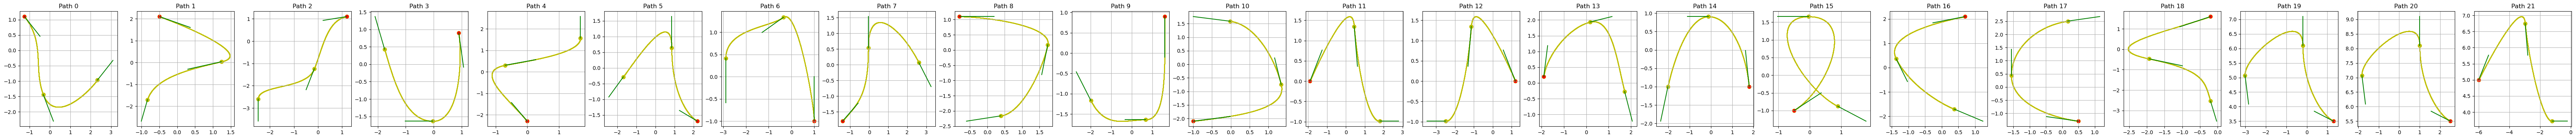

In [11]:
# Visualize the paths

plt.figure(figsize=(4*path_count, 4))
for i in range(path_count):
    plt.subplot(1, path_count, i+1)
    pth_filter = paths_info["Path"] == i
    X = paths_info["Point_X"][pth_filter]
    Y = paths_info["Point_Y"][pth_filter]
    vecs = to_vec(1, paths_info["LookDir"][pth_filter])
    plt.scatter(X, Y)
    plt.plot([X, X + vecs[0]], [Y, Y + vecs[1]], c='g')
    show_path(i)
    plt.scatter(X.iloc[0], Y.iloc[0], c='r')
    plt.title(f"Path {i}")


## Path segmentation

We work with the paths in segments that are integrated in short sub-sequences. To this end we for each segment calculate positions of $k$ equidistant points that are used as positions for the integration process.

In [12]:
def get_spline_data(samples_per_segment, points_per_segment, path_i):
    data = {}
    data["ctrl_points"], data["derivatives"] = info_to_path(*split_path_string(paths[path_i][0], len(paths[path_i][1])))
    data["spline"] = spline_from_points(data["ctrl_points"], data["derivatives"], paths[path_i][1])
    data["lengths"] = []
    data["indices"] = []
    data["samples_per_segment"] = samples_per_segment
    data["points_per_segment"] = points_per_segment
    data["segments"] = len(ctrl_points) - 1
    data["path_i"] = path_i
    
    for stop_i in range(data["segments"]):
        samples = get_samples(samples_per_segment, stop_i)
        lengths = integrate_spline(data["spline"], samples)
        indices = get_equidistan_indices(lengths, points_per_segment)
        data["lengths"].append(lengths)
        data["indices"].append(indices)
        
    return data

In [13]:
def get_PI_curves(samples_per_segment, points_per_segment):
    data = []
    for path_i in range(path_count):
        data.append(get_spline_data(samples_per_segment, points_per_segment, path_i))
    return data

In [14]:
# Generate the segments for the given paths
# recommended is about 1000 samples divided to about 50 equidistant points
# points are selected from the samples, more points -> more precise distances
# This information is used in the integration process, the integration is linear w.r.t. the point count

path_ints = get_PI_curves(1000, 50)
i = 0
for path_i in range(path_count):
    path = path_ints[path_i]
    for seg_i in range(path["segments"]):
        print(f"Distance walked to stop {path_i}-{seg_i}: {path['lengths'][seg_i][-1]:.3f}m")

Distance walked to stop 0-0: 2.782m
Distance walked to stop 0-1: 3.034m
Distance walked to stop 1-0: 3.116m
Distance walked to stop 1-1: 2.841m
Distance walked to stop 2-0: 2.824m
Distance walked to stop 2-1: 2.840m
Distance walked to stop 3-0: 2.989m
Distance walked to stop 3-1: 2.889m
Distance walked to stop 4-0: 3.121m
Distance walked to stop 4-1: 2.838m
Distance walked to stop 5-0: 2.869m
Distance walked to stop 5-1: 3.354m
Distance walked to stop 6-0: 2.870m
Distance walked to stop 6-1: 2.825m
Distance walked to stop 7-0: 2.874m
Distance walked to stop 7-1: 3.633m
Distance walked to stop 8-0: 2.882m
Distance walked to stop 8-1: 2.801m
Distance walked to stop 9-0: 3.024m
Distance walked to stop 9-1: 2.790m
Distance walked to stop 10-0: 2.992m
Distance walked to stop 10-1: 2.821m
Distance walked to stop 11-0: 3.048m
Distance walked to stop 11-1: 2.851m
Distance walked to stop 12-0: 3.048m
Distance walked to stop 12-1: 2.851m
Distance walked to stop 13-0: 2.829m
Distance walked to st

# Data

We either load data from Drive or generate datasets using Gaussian noise (the noise increases with the lenght of the path)

The dataset contains the following fields:

* **Trial state:** Uniquely defines one experimental activity with each value indexed from 0
  * **Block:** a set of trials, usually done at once during experiment
  * **Trial:** one full path taken by the participant
  * **Path:** the ID of the path in this trial
  * **Stop:** paths consist of multiple stopping points (stops), 0 is the starting point
* **Path info:** This is constant information derived from path data, technically redundant, added for convenience
  * **Point_X, Point_Y:** plane coordinates of a stopping point
  * **D_X, D_Y:** vector to the next point (NaN at the end)
  * **D_norm:** length of the above vector
  * **LookDir:** tangent to spline originating in this stopping point
  * **Turn:** Angle turned from the previous point (0 at the beginning)
  * **TurnSign:** what it says
* **Reponse:** The responses given by the participant
  * **Pos_X, Pos_Y:** where the participant actually was when giving answer
  * **d:** the distance to start
  * **phi:** the direction (on unit circle) to start
  * **psi:** the LookDir of the starting point
  * **Pos_X_hat, Pos_Y_hat:** where the participant thought they were when giving answer
  * **d_hat:** the *estimated* distance to start
  * **phi_hat:** the *estimated*  direction (on unit circle) to start
  * **psi_hat:** the *estimated*  LookDir of the starting point



In [15]:
data_columns = ["Block", "Trial", "Path", "Stop",
                "Point_X", "Point_Y", "D_X", "D_Y", "D_norm", "LookDir", "Turn", "TurnSign",
                "Pos_X", "Pos_Y", "d", "phi", "psi", "Pos_X_hat", "Pos_Y_hat", "psi_hat", "omega_hat", "d_hat", "phi_hat"]

# The following accessor functions are used once data has been generated / loaded

def get_active_dataset():
    return part_data

def get_random_act_data():
    return get_active_dataset()[get_rand_key(get_active_dataset())]

In [16]:
def set_assumed_pos(data):
    # Computing where the participant thinks they are
    X_start = data.loc[(data["Stop"] == 0), "Pos_X"].repeat(stop_count).to_numpy()
    Y_start = data.loc[(data["Stop"] == 0), "Pos_Y"].repeat(stop_count).to_numpy()
    resp_vec = np.nan_to_num(to_vec(data["d_hat"].to_numpy(), data["phi_hat"].to_numpy()))
    data["Pos_X_hat"] = X_start - resp_vec[0]
    data["Pos_Y_hat"] = Y_start - resp_vec[1]

## Load data from Drive

In [17]:
data_root = os.path.join(root_folder, data_folder)
#part_pattern = "\d{2}.*_\d{2}_\d{2}_\d{4}_\d{4}"
part_pattern = "\d{2}"
data_folders = [x for x in os.listdir(data_root) if re.match(part_pattern, x)]
part_ids = list(set([f[:4] for f in data_folders]))
logs = {}
for folder in data_folders:
    print(f'Loading {folder}')
    Data = pd.read_csv(os.path.join(data_root, folder, data_filename))
    try:
        Data["Timestamp"] = pd.to_datetime(Data["Timestamp"], format="%y:%m:%d:%H:%M:%S:%f")
    except Exception as e:
        print("Failed to convert timestamps, skipping", e)
        continue
    part_id = folder[:4]
    if part_id in logs:
        logs[part_id] = pd.concat([logs[part_id], Data])
    else:
        logs[part_id] = Data
print(f"Participants found: {sorted(list(logs.keys()))}")

Loading 104
Loading 103
Loading 102
Loading 105
Loading 133
Loading 134
Loading 023
Loading 015
Loading 012
Loading 079
Loading 083
Loading 013
Loading 014
Loading 022
Loading 025
Loading 049
Loading 082
Loading 076
Loading 078
Loading 065
Loading 091
Loading 062
Loading 054
Loading 053
Loading 098
Loading 038
Loading 009
Loading 204
Loading 036
Loading 031
Loading 203
Loading 052
Loading 055
Loading 063
Loading 097
Loading 090
Loading 064
Loading 037
Loading 205
Loading 006
Loading 111
Loading 118
Loading 120
Loading 121
Loading 119
Loading 126
Loading 128
Loading 117
Loading 109
Loading 107
Loading 106
Loading 101
Loading 108
Loading 130
Loading 089
Loading 042
Loading 045
Loading 087
Loading 073
Loading 074
Loading 080
Loading 020
Loading 018
Loading 016
Loading 029
Loading 081
Loading 086
Loading 044
Loading 088
Loading 043
Loading 017
Loading 010
Loading 026
Loading 019
Loading 021
Loading 032
Loading 035
Loading 095
Loading 066
Loading 092
Loading 059
Loading 050
Loading 057
Load

In [18]:
display(logs[get_rand_key(logs)].head(10))

,Timestamp,Head_Pos_X,Head_Pos_Y,Head_Pos_Z,HeadOri,Block,Trial,Path,Stop,EventType,EventValue,Dial
0,2022-06-17 13:48:26.188,1.798,1.320,-1.560,302.308,1,5,5,0,TrialStart,302.31,0
1,2022-06-17 13:49:02.182,0.910,1.311,0.652,341.863,1,5,5,1,AIResponseStart,341.86,0
2,2022-06-17 13:49:15.787,0.793,1.308,0.499,220.685,1,5,5,1,AIResponseEnd,220.68,0
3,2022-06-17 13:49:20.085,0.772,1.307,0.485,219.547,1,5,5,1,PIResponseStart,5.48,0
4,2022-06-17 13:49:36.177,0.840,1.303,0.400,169.509,1,5,5,1,PIResponseEnd,3.86,0
5,2022-06-17 13:50:08.384,-1.664,1.306,-0.171,199.272,1,5,5,2,AIResponseStart,199.27,0
6,2022-06-17 13:50:16.981,-1.529,1.300,-0.127,98.681,1,5,5,2,AIResponseEnd,98.68,0
7,2022-06-17 13:50:19.778,-1.522,1.300,-0.127,98.563,1,5,5,2,PIResponseStart,9.10,0
8,2022-06-17 13:50:32.983,-1.521,1.298,-0.146,97.050,1,5,5,2,PIResponseEnd,4.76,0
9,2022-06-17 13:51:05.280,0.330,1.301,1.834,257.501,1,6,16,0,TrialStart,257.50,0


In [19]:
# Drop the data we're not using
part_ids = list(logs.keys())
for part_id in part_ids:
    part_log = logs[part_id]
    part_log = part_log[part_log["Block"] > 0] # Drop the training block
    counts = part_log.groupby(["Block", "Trial", "Path"]).size().reset_index().rename(columns={0:'StopPoints'})
    if part_id in ["066", "070", "074", "079", "088", "090"]:
        counts["StopPoints"] = (counts["StopPoints"] - 1) / 2 # as these participants give PI response only
    else:
        counts["StopPoints"] = (counts["StopPoints"] - 1) / 4
    if not counts["StopPoints"].isin([segment_count]).all():
        print(f"Participant {part_id}, has data not matching {1, segment_count}, some will be skipped.")
    part_log = part_log.merge(counts, how="inner")
    part_log = part_log[part_log["StopPoints"] == segment_count] # Drop 1-stop paths
    part_log = part_log.drop(columns=["StopPoints"])
    part_log = part_log.reset_index()
    if len(part_log) <= 0:
        print(f"No data for {part_id}, removing")
        logs.pop(part_id, None)
    else:
        logs[part_id] = part_log

Participant 104, has data not matching (1, 2), some will be skipped.
Participant 103, has data not matching (1, 2), some will be skipped.
Participant 102, has data not matching (1, 2), some will be skipped.
Participant 105, has data not matching (1, 2), some will be skipped.
Participant 133, has data not matching (1, 2), some will be skipped.
Participant 134, has data not matching (1, 2), some will be skipped.
Participant 023, has data not matching (1, 2), some will be skipped.
Participant 015, has data not matching (1, 2), some will be skipped.
Participant 012, has data not matching (1, 2), some will be skipped.
Participant 079, has data not matching (1, 2), some will be skipped.
Participant 083, has data not matching (1, 2), some will be skipped.
Participant 013, has data not matching (1, 2), some will be skipped.
Participant 014, has data not matching (1, 2), some will be skipped.
Participant 022, has data not matching (1, 2), some will be skipped.
Participant 025, has data not matc

In [20]:
display(logs[get_rand_key(logs)].head(20))

,index,Timestamp,Head_Pos_X,Head_Pos_Y,Head_Pos_Z,HeadOri,Block,Trial,Path,Stop,EventType,EventValue,Dial
0,0,2022-11-16 10:11:14.810,1.333,1.327,0.610,176.259,1,4,9,0,TrialStart,176.26,0
1,1,2022-11-16 10:11:34.113,0.790,1.326,-1.461,250.099,1,4,9,1,PIResponseStart,2.16,0
2,2,2022-11-16 10:11:50.518,0.782,1.295,-1.444,25.509,1,4,9,1,PIResponseEnd,2.13,0
3,3,2022-11-16 10:11:50.518,0.782,1.295,-1.444,25.509,1,4,9,1,AIResponseStart,25.51,0
4,4,2022-11-16 10:12:05.211,0.812,1.295,-1.403,101.247,1,4,9,1,AIResponseEnd,101.25,0
5,5,2022-11-16 10:12:27.812,-1.826,1.367,-1.217,307.630,1,4,9,2,PIResponseStart,8.52,0
6,6,2022-11-16 10:12:41.518,-1.840,1.350,-1.196,4.883,1,4,9,2,PIResponseEnd,4.92,0
7,7,2022-11-16 10:12:41.518,-1.840,1.350,-1.196,4.883,1,4,9,2,AIResponseStart,4.88,0
8,8,2022-11-16 10:12:54.212,-1.707,1.350,-1.316,52.821,1,4,9,2,AIResponseEnd,52.82,0
9,9,2022-11-16 10:13:19.513,1.761,1.298,-1.558,301.839,1,5,5,0,TrialStart,301.84,0


## Calculate model values from data

In [21]:
def convert_data(part_log):
    data = paths_info.copy()
    # Get position
    part_pos = part_log.loc[part_log["EventType"].isin(["TrialStart", "PIResponseStart"]), ["Block", "Trial", "Path", "Stop", "Head_Pos_X", "Head_Pos_Z"]].rename(columns={"Head_Pos_X" : "Pos_X", "Head_Pos_Z" : "Pos_Y"})
    data = data.merge(part_pos)
    # Get path integration response
    PI_res = part_log.loc[part_log["EventType"].isin(["PIResponseEnd", "TrialStart"]), ["Block", "Trial", "Path", "Stop", "HeadOri", "EventValue"]].rename(columns={"HeadOri" : "phi_hat"})
    PI_res["phi_hat"] = clamp_pi(np.deg2rad(convert_unity_angle(PI_res["phi_hat"])))
    PI_res["d_hat"] = PI_res["EventValue"]
    PI_res.loc[PI_res["Stop"] == 0, "phi_hat"] = np.nan
    PI_res.loc[PI_res["Stop"] == 0, "d_hat"] = np.nan
    data = data.merge(PI_res[["Block", "Trial", "Path", "Stop", "phi_hat", "d_hat"]])
    
    # Sort
    data = data.sort_values(by=["Block", "Trial", "Path", "Stop"])
    data = data.reset_index()
    # Compute the response interpretation
    set_assumed_pos(data)
    return data

In [22]:
part_data=dict()
for id in logs.keys():
    part_data[id] = convert_data(logs[id])
            
display(part_data[get_rand_key(part_data)].head(6))

,index,Path,Stop,Point_X,Point_Y,LookDir,D_X,D_Y,D_norm,Turn,...,d,phi,Block,Trial,Pos_X,Pos_Y,phi_hat,d_hat,Pos_X_hat,Pos_Y_hat
0,75,9,0,1.600000,0.900000,-1.570796,NaN,NaN,NaN,0.000000,...,0.00000,NaN,1,4,1.577,0.618,NaN,NaN,1.577000,0.618000
1,84,9,1,0.676546,-1.637170,3.141593,-0.923454,-2.537170,2.7,-1.570796,...,2.70000,1.221730,1,4,0.961,-1.426,1.459916,3.02,1.242826,-2.383454
2,93,9,2,-1.982435,-1.168320,2.356194,-2.658981,0.468850,2.7,-0.785398,...,4.13664,0.523599,1,4,-1.631,-1.350,2.157314,2.97,3.220789,-1.855633
3,27,5,0,2.200000,-1.700000,2.792527,NaN,NaN,NaN,0.000000,...,0.00000,NaN,1,5,1.996,-1.657,NaN,NaN,1.996000,-1.657000
4,36,5,1,0.850000,0.638269,1.570796,-1.350000,2.338269,2.7,-1.221730,...,2.70000,-1.047198,1,5,0.752,0.701,-0.682546,2.53,0.032798,-0.061150
5,45,5,2,-1.687170,-0.285186,-2.443461,-2.537170,-0.923454,2.7,2.268928,...,4.13664,-0.349066,1,5,-1.664,-0.247,-0.041870,2.35,-0.351940,-1.558633


# Path Integration (PI) Model

In [23]:
def get_part_PI_res(data):
    resp_vecs = to_vec(data["d_hat"].to_numpy(), data["phi_hat"].to_numpy())
    X_S_hat = pd.DataFrame(-resp_vecs.T).fillna(0)
    return X_S_hat


def get_part_PI_segs(data):
    X_S_hat = get_part_PI_res(data)
    return  [X_S_hat[data["Stop"] < (stop_count - 1)].to_numpy(),
             X_S_hat[data["Stop"] > 0].to_numpy()]

def get_part_d_hats(data):
    d_hats = data['d_hat']
    return d_hats[data['Stop']!=0].to_numpy()

def prediction_PI_error(actual, pred):
    diff = actual - pred
    diff_sq = diff ** 2
    sum_of_sq = np.sum(diff_sq, axis=1)
    return np.mean(np.sqrt(sum_of_sq))

def response_PI_error(data):
    # Difference between the physical and responded positions
    selection = data[data["Stop"] > 0]
    actual = selection[["Pos_X", "Pos_Y"]].to_numpy()
    pred = selection[["Pos_X_hat", "Pos_Y_hat"]].to_numpy()
    return prediction_PI_error(actual, pred)

In [24]:
# Test error on random data
print(f"Mean Path integration error: {response_PI_error(get_random_act_data()):.4f}m")

Mean Path integration error: 3.0066m



## Curved version (integral)

In [25]:
def get_seg_vels(data):
    EDists = [] # Distances (on the curve) at the equidistant lengths
    NVels = [] # Normalized velocities
    for index, row in data[data["Stop"] > 0].iterrows():
        path_no = int(row["Path"])
        path = path_ints[path_no]
        segm_no = int(row["Stop"]) - 1
        derivative = path["spline"].derivative()
        
        EDists.append(path["lengths"][segm_no][path["indices"][segm_no]])

        Vels = derivative(path["indices"][segm_no]/path["samples_per_segment"] + segm_no)
        Vels_n = np.linalg.norm(Vels, axis=1)
        NVels.append(Vels.T/Vels_n)
        
    return np.array(EDists), np.array(NVels)

### Bayesian Hierarchical Model

In [26]:
import jax
import numpyro
numpyro.set_host_device_count(4)
import numpyro.distributions as dist
from numpyro.infer.reparam import TransformReparam
import jax.numpy as jnp
import arviz as az
plt.rcParams['figure.constrained_layout.use'] = True

In [39]:
epsilon64jnp = jnp.sqrt(jnp.finfo(jnp.float64).eps)

def bayesian_model_hierarchical_all(N, P, G, part_group, part_ids, Xs, Xs_next, EDists, NVels, d_hats, configs):
    
    # Define group-level parameters: gamma and tau
    with numpyro.plate("group_plate", G):
        if configs['alpha']['type'] == 'sample':
            gamma_alpha = numpyro.sample("gamma_alpha", configs['alpha']['gamma_dist'](configs['alpha']['gamma_mean'], configs['alpha']['gamma_scale']))
            tau_alpha = numpyro.sample("tau_alpha", configs['alpha']['tau_dist'](configs['alpha']['tau_scale']))
        if configs['beta']['type'] == 'sample':
            gamma_beta = numpyro.sample("gamma_beta", configs['beta']['gamma_dist'](configs['beta']['gamma_mean'], configs['beta']['gamma_scale']))
            tau_beta = numpyro.sample("tau_beta", configs['beta']['tau_dist'](configs['beta']['tau_scale']))
        if configs['b']['type'] == 'sample':
            gamma_bx = numpyro.sample("gamma_bx", configs['b']['gamma_dist'](configs['b']['gamma_mean_bx'], configs['b']['gamma_scale_bx']))
            gamma_by = numpyro.sample("gamma_by", configs['b']['gamma_dist'](configs['b']['gamma_mean_by'], configs['b']['gamma_scale_by']))
            tau_bx = numpyro.sample("tau_bx", configs['b']['tau_dist'](configs['b']['tau_scale_bx']))
            tau_by = numpyro.sample("tau_by", configs['b']['tau_dist'](configs['b']['tau_scale_by']))
        if configs['sigma']['type'] == 'sample':
            gamma_sigma = numpyro.sample("gamma_sigma", dist.TransformedDistribution(configs['sigma']['gamma_dist'](configs['sigma']['gamma_mean'], configs['sigma']['gamma_scale']), dist.transforms.SoftplusTransform()))
            tau_sigma = numpyro.sample("tau_sigma", configs['sigma']['tau_dist'](configs['sigma']['tau_scale']))
        if configs['sigma_r']['type'] == 'sample':
            gamma_sigma_r = numpyro.sample("gamma_sigma_r", dist.TransformedDistribution(configs['sigma_r']['gamma_dist'](configs['sigma_r']['gamma_mean'], configs['sigma_r']['gamma_scale']), dist.transforms.SoftplusTransform()))
            tau_sigma_r = numpyro.sample("tau_sigma_r", configs['sigma_r']['tau_dist'](configs['sigma_r']['tau_scale']))
        
    # participant level parameters
    with numpyro.plate("participant_plate", P):
        if configs['alpha']['type'] == 'sample': 
            alpha_participant = numpyro.sample('alpha_participant', configs['alpha']['gamma_dist'](gamma_alpha[part_group], tau_alpha[part_group]))
        if configs['beta']['type'] == 'sample':
            beta_participant = numpyro.sample("beta_participant", configs['beta']['gamma_dist'](gamma_beta[part_group], tau_beta[part_group]))
        if configs['b']['type'] == 'sample':
            with numpyro.handlers.reparam(config={'bx_participant': TransformReparam()}): 
                bx_participant = numpyro.sample('bx_participant', dist.TransformedDistribution(configs['b']['gamma_dist'](0., 5.), dist.transforms.AffineTransform(gamma_bx[part_group], tau_bx[part_group])))
            with numpyro.handlers.reparam(config={'by_participant': TransformReparam()}): 
                by_participant = numpyro.sample('by_participant', dist.TransformedDistribution(configs['b']['gamma_dist'](0., 5.), dist.transforms.AffineTransform(gamma_by[part_group], tau_by[part_group])))
        if configs['sigma']['type'] == 'sample':
            sigma_participant = numpyro.sample('sigma_participant', dist.TransformedDistribution(configs['sigma']['gamma_dist'](gamma_sigma[part_group], tau_sigma[part_group]), dist.transforms.SoftplusTransform()))
        if configs['sigma_r']['type'] == 'sample':
            sigma_r_participant = numpyro.sample('sigma_r_participant', dist.TransformedDistribution(configs['sigma_r']['gamma_dist'](gamma_sigma_r[part_group], tau_sigma_r[part_group]), dist.transforms.SoftplusTransform()))
    
    if configs['alpha']['type'] == 'sample':
        alpha = alpha_participant[part_ids]
    elif configs['alpha']['type'] == 'fixed':
        alpha = numpyro.deterministic("alpha_participant", value=jnp.ones(N))
    
    if configs['beta']['type'] == 'sample':
        beta = beta_participant[part_ids]
    elif configs['beta']['type'] == 'fixed':
        beta = numpyro.deterministic("beta_participant", jnp.zeros(N))
    #regularize beta
    beta = jnp.where(jnp.abs(beta)>epsilon64jnp, beta, jnp.where(beta!=0, epsilon64jnp * jnp.sign(beta), epsilon64jnp))
    
    if configs['b']['type'] == 'sample':
        bx = bx_participant[part_ids]
        by = by_participant[part_ids]
        b = numpyro.deterministic("b_participant", jnp.stack([bx, by], axis=-1))
    elif configs['b']['type'] == 'fixed':
        b = numpyro.deterministic("b_participant", jnp.zeros((N, 2)))
    
    if configs['sigma']['type'] == 'sample':
        sigma_sq = numpyro.deterministic("sigma_sq_participant", jnp.square(sigma_participant[part_ids]))
    elif configs['sigma']['type'] == 'fixed':
        sigma = numpyro.deterministic("sigma_participant", jnp.zeros(N))
        sigma_sq = numpyro.deterministic("sigma_sq_participant", jnp.square(sigma))
    sigma_sq = jnp.where(sigma_sq==0.0, jnp.finfo(jnp.float64).eps, sigma_sq)
    
    if configs['sigma_r']['type'] == 'sample':
        sigma_r_sq = numpyro.deterministic("sigma_r_sq_participant", jnp.square(sigma_r_participant[part_ids]*d_hats))
    elif configs['sigma_r']['type'] == 'fixed':
        sigma_r = numpyro.deterministic("sigma_r_participant", jnp.zeros(N))
        sigma_r_sq = numpyro.deterministic("sigma_r_sq_participant", jnp.square(sigma_r))
    sigma_r_sq = jnp.where(sigma_r_sq==0.0, jnp.finfo(jnp.float64).eps, sigma_r_sq)
    
    # calculate likelihood mu and covariance
    Ls = EDists.T[-1] # size (N, )
    exp_term = jnp.exp(-beta[:, None]*Ls[:, None]) #size (N,1)
    integrand = jnp.exp(beta[:,None, None]*EDists[:,None,:]) * NVels #size (N,2,sample_num)
    integral = jnp.trapz(integrand, EDists[:,None,:]) # integral should have dimension (N,2)
    bias_term = (b/beta[:, None])*(1.0 - exp_term) # have dimension (N,2)
    pos_term = (alpha[:, None] * exp_term) * integral #size (N,2)
    cov = (sigma_sq/(2*beta)) * (1 - jnp.exp(-2*beta*Ls)) #size (N,1)
    cov = jnp.where(cov==0.0, jnp.finfo(jnp.float64).eps, cov)
    mu_next = (exp_term * Xs) + pos_term + bias_term # should have dimension (N,2)
    cov_next = cov[:, None, None] * jnp.eye(2)[None, :] # should have dimension (N,2,2)
    cov_r = sigma_r_sq[:, None, None] *jnp.eye(2)[None, :] # should have dimension (N, 2, 2)
    
    # Use plate for the loop over N
    with numpyro.plate("data_plate", size = N):
        numpyro.sample("Xs_next", dist.MultivariateNormal(mu_next, cov_next+cov_r), obs=Xs_next)

In [40]:
def PI_convert_params(params):
    alpha, beta, b_x, b_y, sigma, sigma_r = params
    beta = regularize_param(beta) # converting it for stabilizing the simulations
    sigma_sq = sigma **2
    b = np.array([b_x, b_y])
    return alpha, beta, sigma_sq, b, sigma_r


def PI_analytical_mean_int(X_s, EDists, NVels, alpha, beta, b):
    Ls = EDists.T[-1]
    exp_axis = len(EDists.shape) - 1
    integrand = np.expand_dims(np.exp(beta * EDists), axis=exp_axis) * NVels
    exp_term = np.exp(-beta*Ls)
    pos_term = (alpha * exp_term * integrate.simps(integrand, np.expand_dims(EDists, axis=exp_axis)).T).T
    bias_term = np.outer(b / beta, 1 - exp_term)
    return (X_s.T * exp_term).T + pos_term + bias_term.T

def PI_analytical_variance_int(EDists, beta, sigma_sq):
    Ls = EDists.T[-1]
    return sigma_sq/(2*beta) * (1 - np.exp(-2*beta*Ls))

def pred_path_PI_int(EDists, NVels, ds, params):
    alpha, beta, sigma_sq, b, sigma_r = PI_convert_params(params)
    X_s = [np.array([0, 0])]
    for segment_i in range(len(EDists)):
        edist = EDists[segment_i]
        nvel = NVels[segment_i]
        d = ds[segment_i]
        mu_next = PI_analytical_mean_int(X_s[-1], edist, nvel, alpha, beta, b)[0]
        sigma_sq_next = PI_analytical_variance_int(edist, beta, sigma_sq)
        sigma_sq_next = epsilon64 if sigma_sq_next == 0.0 else sigma_sq_next
        sigma_r = epsilon64 if sigma_r == 0.0 else sigma_r
        x_s_next = stats.multivariate_normal.rvs(mu_next, np.identity(2) * (sigma_sq_next+(sigma_r*d)**2))
        X_s.append(x_s_next)
    return X_s

def pred_all_PI_int(EDists_all, NVels_all, ds_all, params):
    result = []
    EDists_split = t_split(EDists_all)
    NVels_split = t_split(NVels_all)
    ds_split = t_split(ds_all)
    trial_count = len(EDists_split)
    
    for trial_i in range(trial_count):
        result.append(pred_path_PI_int(EDists_split[trial_i], NVels_split[trial_i], ds_split[trial_i], params))
    
    return result

In [41]:
def get_PI_result_table_Bayesian(result_infer_data, result_loo_data, dataset, configs):
    """
    collects individual level parameters into a pandas dataframe
    """
    PI_table_dict = {}
    PI_table_dict['id'] = []
    PI_table_dict['alpha'] = []
    PI_table_dict['beta'] = []
    PI_table_dict['b_x'] = []
    PI_table_dict['b_y'] = []
    PI_table_dict['b'] = []
    PI_table_dict['sigma'] = []
    PI_table_dict['sigma_sq'] = []
    PI_table_dict['sigma_r'] = []
    PI_table_dict['sigma_r_sq'] = []
    PI_table_dict['Group'] = []
    PI_table_dict['elpd_loo'] = []
    PI_table_dict['MSE'] = []

    part_data_start_idx = 0
    for i, part_id in enumerate(dataset.keys()):
        if configs['alpha']['type'] == 'sample':
            alpha_mean = result_infer_data.posterior['alpha_participant'].values[:,:, i].mean()
        elif configs['alpha']['type'] == 'fixed':
            alpha_mean = 1.
        
        if configs['beta']['type'] == 'sample':
            beta_mean = result_infer_data.posterior['beta_participant'].values[:,:, i].mean()
        elif configs['beta']['type'] == 'fixed':
            beta_mean = 0.
        
        if configs['b']['type'] == 'sample':
            b_x_mean = result_infer_data.posterior['bx_participant'].values[:,:, i].mean()
            b_y_mean = result_infer_data.posterior['by_participant'].values[:,:, i].mean()
        elif configs['b']['type'] == 'fixed':
            b_x_mean = 0.
            b_y_mean = 0.
        
        if configs['sigma']['type'] == 'sample':
            sigma_mean = result_infer_data.posterior['sigma_participant'].values[:,:, i].mean()
        elif configs['sigma']['type'] == 'fixed':
            sigma_mean = 0.
        
        if configs['sigma_r']['type'] == 'sample':
            sigma_r_mean = result_infer_data.posterior['sigma_r_participant'].values[:,:, i].mean()
        elif configs['sigma_r']['type'] == 'fixed':
            sigma_r_mean = 0.
            
        b_bayes_mean = (b_x_mean**2 + b_y_mean**2) ** 0.5
        sigma_sq_mean = sigma_mean ** 2
        sigma_r_sq_mean = sigma_r_mean ** 2

        # mse calculations
        EDists, NVels = get_seg_vels(dataset[part_id])
        ds = get_part_d_hats(dataset[part_id])
        preds = pred_all_PI_int(EDists, NVels, ds, [alpha_mean, beta_mean, b_x_mean, b_y_mean, sigma_mean, sigma_r_mean]) # is res.x a list or an array
        mse = prediction_PI_error(get_part_PI_res(dataset[part_id]), t_join(preds))

        PI_table_dict['id'].append(part_id)
        PI_table_dict['alpha'].append(alpha_mean)
        PI_table_dict['beta'].append(beta_mean)
        PI_table_dict['b_x'].append(b_x_mean)
        PI_table_dict['b_y'].append(b_y_mean)
        PI_table_dict['b'].append(b_bayes_mean)
        PI_table_dict['sigma'].append(sigma_mean)
        PI_table_dict['sigma_sq'].append(sigma_sq_mean)
        PI_table_dict['sigma_r'].append(sigma_r_mean)
        PI_table_dict['sigma_r_sq'].append(sigma_r_sq_mean)
        PI_table_dict['Group'].append('SCD' if (part_id.startswith('1') or part_id.startswith('2')) else 'Control')
        PI_table_dict['elpd_loo'].append(result_loo_data.loo_i.values[part_data_start_idx: part_data_start_idx + EDists.shape[0]].sum())
        PI_table_dict['MSE'].append(mse)
        part_data_start_idx = part_data_start_idx + EDists.shape[0]
    

    PI_table_df = pd.DataFrame.from_dict(PI_table_dict)
    
    return PI_table_df

In [42]:
def plot_results(result_df):
    """
    plots individual level parameters
    """
    fig = plt.figure(figsize=(10, 3))
    parameters = ["alpha", "beta", "b", "sigma_sq", "sigma_r"]
    grid = fig.add_gridspec(1, len(parameters))

    for i, param in enumerate(parameters):
        ax = fig.add_subplot(grid[0, i])
        sns.boxplot(data=result_df, x = "Group", y = param, showfliers = False)

    fig.tight_layout()

In [43]:
"""
preparare the whole dataset with all the participants and label them with 1->Control and 0->SCD
design:
       1. Append all the observations after going through all the pariticipant keys 
       2. Add the participant ids to each of the observations
       3. Assign 0 or 1 to each of the participant
"""
# merge the whole data and get the ids and groups for all the participants
id_num = 0
ids = []
groups =[]

X_s_all = []
X_s_next_all = []
EDists_all = []
NVels_all = [] 
d_hats_all = []

i=0
for key, data in part_data.items():
    group = 0 if (key.startswith('1') or key.startswith('2')) else 1
    groups.append(group)

    X_s, X_s_next = get_part_PI_segs(data)
    EDists, NVels = get_seg_vels(data)
    d_hats = get_part_d_hats(data)
    ids += [id_num]*X_s.shape[0]
    id_num+=1
    X_s_all.append(X_s)
    X_s_next_all.append(X_s_next)

    # appending
    EDists_all.append(EDists)
    NVels_all.append(NVels)
    d_hats_all.append(d_hats)
    i += 1

X_s_all = np.concatenate(X_s_all)
X_s_next_all = np.concatenate(X_s_next_all)
EDists_all = np.concatenate(EDists_all)
NVels_all = np.concatenate(NVels_all)
d_hats_all = np.concatenate(d_hats_all)

In [49]:
# input data
data_hierarchical = {
    "N": X_s_all.shape[0],
    "P": len(part_data.keys()),
    "G": 2,
    "part_group": jnp.array(groups.copy()),
    "part_ids": jnp.array(ids.copy()),
    "Xs": jnp.array(X_s_all),
    "Xs_next": jnp.array(X_s_next_all),
    "EDists": jnp.array(EDists_all),
    "NVels": jnp.array(NVels_all),
    "d_hats": jnp.array(d_hats_all),
    "configs": {
        'alpha': {
            'type': 'sample',
            'gamma_dist': dist.Normal,
            'gamma_mean': 1.,
            'gamma_scale': 10.,
            'tau_dist': dist.HalfCauchy,
            'tau_scale': 5.
        },
        'beta':{
            'type': 'sample',
            'gamma_dist': dist.Normal,
            'gamma_mean': 0.,
            'gamma_scale': 10.,
            'tau_dist': dist.HalfCauchy,
            'tau_scale': 5.
        },
        'b':{
            'type': 'sample',
            'gamma_dist': dist.Normal,
            'gamma_mean_bx': 0.,
            'gamma_mean_by': 0.,
            'gamma_scale_bx': 10.,
            'gamma_scale_by': 10.,
            'tau_dist': dist.HalfCauchy,
            'tau_scale_bx': 5.,
            'tau_scale_by': 5.,
        },
        'sigma':{
            'type': 'sample',
            'gamma_dist': dist.Normal,
            'gamma_mean': 0.,
            'gamma_scale': 1.,
            'tau_dist': dist.HalfCauchy,
            'tau_scale': 5.
        },
        'sigma_r':{
            'type': 'sample',
            'gamma_dist': dist.Normal,
            'gamma_mean': 0.,
            'gamma_scale': 1.,
            'tau_dist': dist.HalfCauchy,
            'tau_scale': 5.
        },
    }
}

In [50]:
rng_key = jax.random.PRNGKey(0)
# Run the model
kernel = numpyro.infer.NUTS(bayesian_model_hierarchical_all)
mcmc = numpyro.infer.MCMC(kernel, num_chains=4, num_warmup=1000, num_samples=1000)
mcmc.run(rng_key, **data_hierarchical)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [51]:
mcmc.print_summary()


                             mean       std    median      5.0%     95.0%     n_eff     r_hat
   alpha_participant[0]      0.55      0.06      0.55      0.46      0.65   4266.33      1.00
   alpha_participant[1]      0.22      0.11      0.21      0.05      0.38   1430.53      1.00
   alpha_participant[2]     -0.25      0.09     -0.25     -0.40     -0.10   5925.75      1.00
   alpha_participant[3]      2.60      0.79      2.55      1.42      3.98   1958.85      1.00
   alpha_participant[4]      0.79      0.08      0.79      0.65      0.92   3401.95      1.00
   alpha_participant[5]      0.73      0.04      0.73      0.67      0.80   4961.86      1.00
   alpha_participant[6]      1.09      0.09      1.09      0.95      1.24   2982.08      1.00
   alpha_participant[7]      0.72      0.13      0.71      0.51      0.93   3070.50      1.00
   alpha_participant[8]      0.45      0.10      0.45      0.29      0.60   4350.33      1.00
   alpha_participant[9]      1.26      0.09      1.26      

array([[<Axes: title={'center': 'gamma_alpha'}>,
        <Axes: title={'center': 'gamma_alpha'}>],
       [<Axes: title={'center': 'gamma_beta'}>,
        <Axes: title={'center': 'gamma_beta'}>],
       [<Axes: title={'center': 'gamma_bx'}>,
        <Axes: title={'center': 'gamma_bx'}>],
       [<Axes: title={'center': 'gamma_by'}>,
        <Axes: title={'center': 'gamma_by'}>],
       [<Axes: title={'center': 'gamma_sigma'}>,
        <Axes: title={'center': 'gamma_sigma'}>],
       [<Axes: title={'center': 'gamma_sigma_r'}>,
        <Axes: title={'center': 'gamma_sigma_r'}>]], dtype=object)

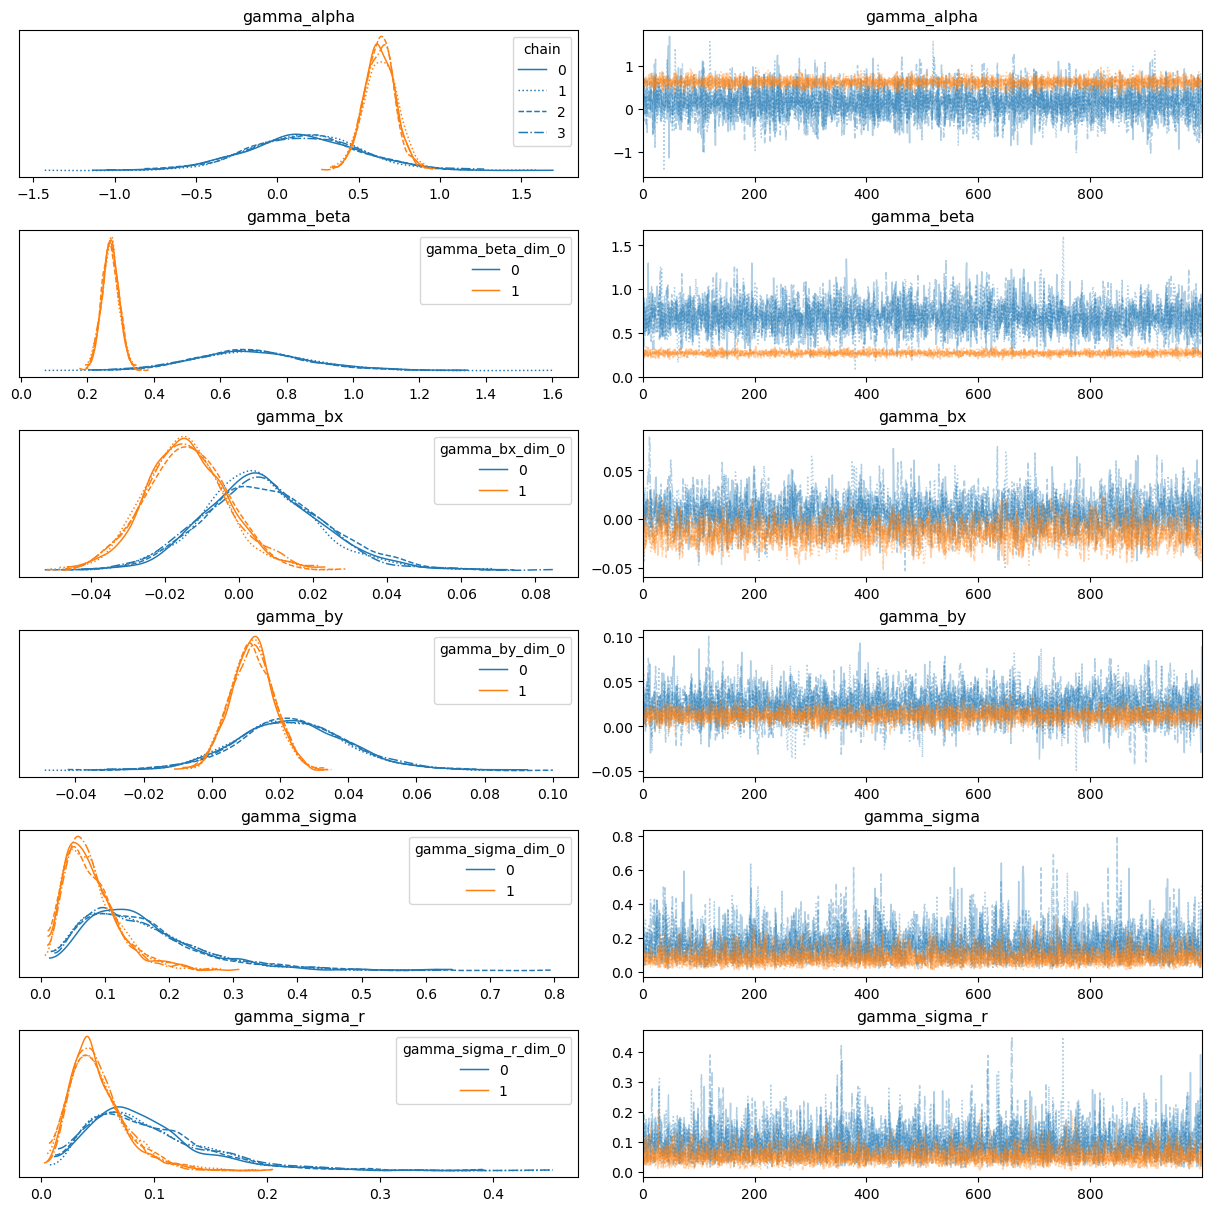

In [52]:
az.plot_trace(mcmc, var_names=['gamma_alpha', 'gamma_beta', 'gamma_bx', "gamma_by", "gamma_sigma", "gamma_sigma_r"], legend=True, divergences=None)

In [53]:
infer_data = az.from_numpyro(posterior = mcmc)

In [54]:
data_loo = az.loo(infer_data)

/opt/anaconda3/envs/numpyroEnv2/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


In [55]:
data_loo

Computed from 4000 posterior samples and 12420 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -43465.65   141.60
p_loo      395.61        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     12394   99.8%
 (0.5, 0.7]   (ok)          15    0.1%
   (0.7, 1]   (bad)         10    0.1%
   (1, Inf)   (very bad)     1    0.0%

In [48]:
PI_table_bayes = get_PI_result_table_Bayesian(infer_data, data_loo, part_data, data_hierarchical['configs'])

In [49]:
PI_table_bayes

,id,alpha,beta,b_x,b_y,b,sigma,sigma_sq,sigma_r,sigma_r_sq,Group,elpd_loo,MSE
0,104,0.553944,0.238048,0.016262,-0.004802,0.016956,0.253362,0.064192,0.484106,0.234359,SCD,-457.921904,1.506446
1,103,0.223998,0.570766,0.006631,0.049765,0.050204,0.247929,0.061469,0.674324,0.454713,SCD,-638.029835,2.349557
2,102,-0.245337,0.196968,0.075307,-0.065075,0.099528,0.392661,0.154182,0.589424,0.347421,SCD,-362.030359,2.732574
3,105,2.597750,1.975789,0.013489,0.033919,0.036503,1.324818,1.755142,0.612924,0.375675,SCD,-638.629613,3.259198
4,133,0.791152,0.203861,-0.029752,-0.006197,0.030390,0.416098,0.173138,0.390625,0.152588,SCD,-322.274691,1.553232
...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,094,0.082455,0.333091,-0.143717,0.010976,0.144136,0.150245,0.022574,0.658985,0.434262,Control,-462.536008,3.201037
91,115,0.014753,1.106107,0.008327,0.024542,0.025916,0.399712,0.159770,0.696231,0.484738,SCD,-400.609814,2.580669
92,125,-0.051901,0.220295,-0.018765,0.037194,0.041660,0.253544,0.064284,0.631053,0.398228,SCD,-524.713778,2.241834
93,122,0.169433,0.293695,0.045662,-0.002130,0.045712,0.379592,0.144090,0.629673,0.396489,SCD,-542.006140,2.734959


/var/folders/g1/_gwbcvb938z0_b8101r297s00000gn/T/ipykernel_88703/371656829.py:10: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


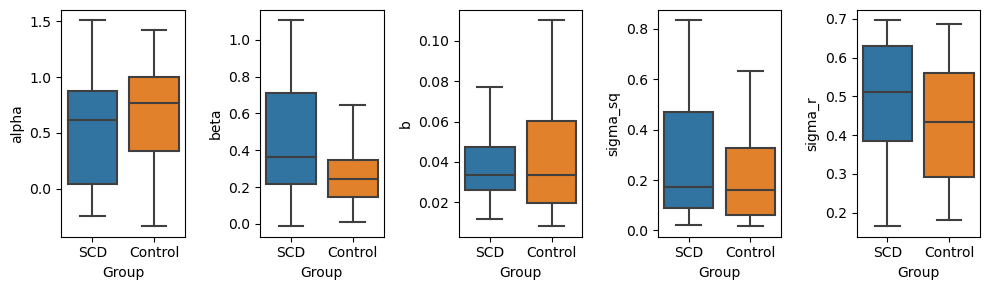

In [51]:
plot_results(PI_table_bayes)

In [60]:
# fixing different combinations of model parameters

In [91]:
import itertools

param_list = ['alpha', 'beta', 'b', 'sigma', 'sigma_r']
param_combs=[]
for i in range(len(param_list)+1):
    l = [list(x) for x in itertools.combinations(param_list, r=i)]
    param_combs.extend(l)

In [92]:
for param_comb in param_combs:
    if {'sigma', 'sigma_r'}.issubset(param_comb):
        # to skip the combinations where both are fixed
        continue
    data_hierarchical = {
        "N": X_s_all.shape[0],
        "P": len(part_data.keys()),
        "G": 2,
        "part_group": jnp.array(groups.copy()),
        "part_ids": jnp.array(ids.copy()),
        "Xs": jnp.array(X_s_all),
        "Xs_next": jnp.array(X_s_next_all),
        "EDists": jnp.array(EDists_all),
        "NVels": jnp.array(NVels_all),
        "d_hats": jnp.array(d_hats_all),
        "configs": {
            'alpha': {
                'type': 'sample',
                'gamma_dist': dist.Normal,
                'gamma_mean': 1.,
                'gamma_scale': 10.,
                'tau_dist': dist.HalfCauchy,
                'tau_scale': 5.
            },
            'beta':{
                'type': 'sample',
                'gamma_dist': dist.Normal,
                'gamma_mean': 0.,
                'gamma_scale': 10.,
                'tau_dist': dist.HalfCauchy,
                'tau_scale': 5.
            },
            'b':{
                'type': 'sample',
                'gamma_dist': dist.Normal,
                'gamma_mean_bx': 0.,
                'gamma_mean_by': 0.,
                'gamma_scale_bx': 10.,
                'gamma_scale_by': 10.,
                'tau_dist': dist.HalfCauchy,
                'tau_scale_bx': 5.,
                'tau_scale_by': 5.,
            },
            'sigma':{
                'type': 'sample',
                'gamma_dist': dist.Normal,
                'gamma_mean': 0.,
                'gamma_scale': 1.,
                'tau_dist': dist.HalfCauchy,
                'tau_scale': 5.
            },
            'sigma_r':{
                'type': 'sample',
                'gamma_dist': dist.Normal,
                'gamma_mean': 0.,
                'gamma_scale': 1.,
                'tau_dist': dist.HalfCauchy,
                'tau_scale': 5.
            },
        }
    }
    f_name = "PI_curved_Bayesian_reporting_noise_f(d_hat)_"
    for fix_param in param_comb:
        data_hierarchical['configs'][fix_param]['type'] = 'fixed'
        f_name = f_name+fix_param+"_"
    f_name = f_name+'fixed'
    print("Starting Fixed_params {}".format(param_comb))
    print(f_name)
    
    rng_key = jax.random.PRNGKey(0)
    # Run the model
    kernel = numpyro.infer.NUTS(bayesian_model_hierarchical_all) # with reporting noise
    mcmc = numpyro.infer.MCMC(kernel, num_chains=4, num_warmup=2000, num_samples=1000)
    mcmc.run(rng_key, **data_hierarchical)
    infer_data = az.from_numpyro(posterior = mcmc) # Convert NumPyro data into an InferenceData object
    infer_data.to_netcdf(f_name+'.nc')
    data_loo = az.loo(infer_data) # get the loos
    PI_table_bayes = get_PI_result_table_Bayesian(infer_data, data_loo, part_data, data_hierarchical['configs'])
    # save the re sultant parameters
    PI_table_bayes.to_csv(f_name+'.csv')

Starting Fixed_params []
PI_curved_Bayesian_reporting_noise_f(d_hat)_fixed


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

/opt/anaconda3/envs/numpyroEnv2/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Starting Fixed_params ['alpha']
PI_curved_Bayesian_reporting_noise_f(d_hat)_alpha_fixed


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

/opt/anaconda3/envs/numpyroEnv2/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Starting Fixed_params ['beta']
PI_curved_Bayesian_reporting_noise_f(d_hat)_beta_fixed


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

/opt/anaconda3/envs/numpyroEnv2/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Starting Fixed_params ['b']
PI_curved_Bayesian_reporting_noise_f(d_hat)_b_fixed


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

/opt/anaconda3/envs/numpyroEnv2/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Starting Fixed_params ['sigma']
PI_curved_Bayesian_reporting_noise_f(d_hat)_sigma_fixed


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

/opt/anaconda3/envs/numpyroEnv2/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Starting Fixed_params ['sigma_r']
PI_curved_Bayesian_reporting_noise_f(d_hat)_sigma_r_fixed


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

/opt/anaconda3/envs/numpyroEnv2/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Starting Fixed_params ['alpha', 'beta']
PI_curved_Bayesian_reporting_noise_f(d_hat)_alpha_beta_fixed


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

/opt/anaconda3/envs/numpyroEnv2/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Starting Fixed_params ['alpha', 'b']
PI_curved_Bayesian_reporting_noise_f(d_hat)_alpha_b_fixed


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

/opt/anaconda3/envs/numpyroEnv2/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Starting Fixed_params ['alpha', 'sigma']
PI_curved_Bayesian_reporting_noise_f(d_hat)_alpha_sigma_fixed


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

/opt/anaconda3/envs/numpyroEnv2/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Starting Fixed_params ['alpha', 'sigma_r']
PI_curved_Bayesian_reporting_noise_f(d_hat)_alpha_sigma_r_fixed


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Starting Fixed_params ['beta', 'b']
PI_curved_Bayesian_reporting_noise_f(d_hat)_beta_b_fixed


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

/opt/anaconda3/envs/numpyroEnv2/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Starting Fixed_params ['beta', 'sigma']
PI_curved_Bayesian_reporting_noise_f(d_hat)_beta_sigma_fixed


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

/opt/anaconda3/envs/numpyroEnv2/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Starting Fixed_params ['beta', 'sigma_r']
PI_curved_Bayesian_reporting_noise_f(d_hat)_beta_sigma_r_fixed


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Starting Fixed_params ['b', 'sigma']
PI_curved_Bayesian_reporting_noise_f(d_hat)_b_sigma_fixed


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

/opt/anaconda3/envs/numpyroEnv2/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Starting Fixed_params ['b', 'sigma_r']
PI_curved_Bayesian_reporting_noise_f(d_hat)_b_sigma_r_fixed


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

/opt/anaconda3/envs/numpyroEnv2/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Starting Fixed_params ['alpha', 'beta', 'b']
PI_curved_Bayesian_reporting_noise_f(d_hat)_alpha_beta_b_fixed


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

/opt/anaconda3/envs/numpyroEnv2/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Starting Fixed_params ['alpha', 'beta', 'sigma']
PI_curved_Bayesian_reporting_noise_f(d_hat)_alpha_beta_sigma_fixed


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

/opt/anaconda3/envs/numpyroEnv2/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Starting Fixed_params ['alpha', 'beta', 'sigma_r']
PI_curved_Bayesian_reporting_noise_f(d_hat)_alpha_beta_sigma_r_fixed


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Starting Fixed_params ['alpha', 'b', 'sigma']
PI_curved_Bayesian_reporting_noise_f(d_hat)_alpha_b_sigma_fixed


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

/opt/anaconda3/envs/numpyroEnv2/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Starting Fixed_params ['alpha', 'b', 'sigma_r']
PI_curved_Bayesian_reporting_noise_f(d_hat)_alpha_b_sigma_r_fixed


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Starting Fixed_params ['beta', 'b', 'sigma']
PI_curved_Bayesian_reporting_noise_f(d_hat)_beta_b_sigma_fixed


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

/opt/anaconda3/envs/numpyroEnv2/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Starting Fixed_params ['beta', 'b', 'sigma_r']
PI_curved_Bayesian_reporting_noise_f(d_hat)_beta_b_sigma_r_fixed


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Starting Fixed_params ['alpha', 'beta', 'b', 'sigma']
PI_curved_Bayesian_reporting_noise_f(d_hat)_alpha_beta_b_sigma_fixed


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

/opt/anaconda3/envs/numpyroEnv2/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Starting Fixed_params ['alpha', 'beta', 'b', 'sigma_r']
PI_curved_Bayesian_reporting_noise_f(d_hat)_alpha_beta_b_sigma_r_fixed


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]